This is the notebook to run the seq2seq network. It starts with a preprocessed file with calib being the value to predict, and int_deliv_inv_ub and calib_time being the best values to use.

Also, I'm running this in the Python 3.6.3 Kernel

In [1]:
#import the stuff
import pandas as pd #dataframes etc
import matplotlib.pyplot as plt #plotting
import numpy as np
from sklearn import preprocessing
from common.utils import TimeSeriesTensor, create_evaluation_df, mape, scale_shrinker
#now we bring in the keras tensorflow model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense, LSTM, SimpleRNN
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import MeanSquaredLogarithmicError, MeanSquaredError
from tensorflow.keras import Input
from tensorflow.keras.utils import plot_model

import tensorflow.keras
import pydot
import pydotplus
from pydotplus import graphviz
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import model_to_dot
tensorflow.keras.utils.pydot = pydot
from tensorflow.keras.utils import plot_model    


from math import pow, floor
import time

In [5]:
#load the data
#we are loaded differenced (but not scaled) data from 2018 for crystal 54000
test = pd.read_csv('../dataframes/test_diff_18_54000.csv', index_col=0)
valid = pd.read_csv('../dataframes/valid_diff_18_54000.csv', index_col=0)
train = pd.read_csv('../dataframes/train_diff_18_54000.csv', index_col=0)

#set index to datetime
test.index = pd.to_datetime(test.index)
valid.index = pd.to_datetime(valid.index)

train = train.append(valid)
train.index = pd.to_datetime(train.index)
train.head()

,calibration,int_deliv_inv_ub
2018-05-12 09:01:31,0.000267,1.912590e+07
2018-05-12 10:01:31,0.000199,1.786448e+07
2018-05-12 11:01:31,0.000203,1.664305e+07
2018-05-12 12:01:31,0.000395,3.387666e+07
2018-05-12 13:01:31,0.000471,3.200991e+07


In [6]:
valid.head()

,calibration,int_deliv_inv_ub
2018-08-31 01:15:27,0.000081,9.133316e+00
2018-08-31 02:15:27,-0.000618,5.955598e+06
2018-08-31 03:15:27,-0.000824,1.468409e+07
2018-08-31 04:15:27,-0.000983,2.532678e+07
2018-08-31 05:15:27,-0.000987,3.361170e+07


In [7]:
#now we will scale the data, lately, I've been using the StandardScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
y_scaler = StandardScaler() #we'll use the y-scaler later
y_scaler.fit(train[['calibration']])
train[['calibration', 'int_deliv_inv_ub']] = scaler.fit_transform(train)
train.describe()


,calibration,int_deliv_inv_ub
count,3.734000e+03,3.734000e+03
mean,-5.583821e-17,9.540366e-16
std,1.000134e+00,1.000134e+00
min,-4.202259e+00,-8.723725e-01
25%,-1.913427e-01,-8.723725e-01
50%,1.828191e-01,-4.990744e-01
75%,5.939159e-01,8.539998e-01
max,3.162806e+00,2.434275e+00


In [8]:
test[['calibration', 'int_deliv_inv_ub']] = scaler.transform(test)
test.describe()

,calibration,int_deliv_inv_ub
count,1166.000000,1166.000000
mean,0.030238,-0.604342
std,0.607155,0.677265
min,-3.891640,-0.872372
25%,-0.089422,-0.872372
50%,0.060977,-0.872372
75%,0.257269,-0.872371
max,2.381403,2.171737


In [9]:
#our data will look like 24hr sections of luminosity and 24hr sections of calibrations
HORIZON = 24 #24hrs
train_shifted = train.copy()
calibration_shifted = train_shifted[['calibration']]
lumi_shifted = train_shifted[['int_deliv_inv_ub']]
for t in range(1, HORIZON):
    calibration_shifted['calibration+'+str(t)] = calibration_shifted['calibration'].shift(-t, freq='H')
    lumi_shifted['int_deliv_inv_ub+'+str(t)] = lumi_shifted['int_deliv_inv_ub'].shift(-t, freq='H')
#each row in each of the dataframes corresponds to 24hrs of data
target_seq = calibration_shifted.dropna()
input_seq = lumi_shifted.dropna()

#convert to np array
target_np = target_seq.to_numpy() #[row:column]
input_np = input_seq.to_numpy()

#we also want to create an 'over by 1' version of the target sequence to train the decoder
#we'll stick with a 0 padding for now
target_np_shifted = np.pad(target_np, ((0,0),(1,0)), mode='constant')[:,0:-1]

In [10]:
batch_size = 64  # Batch size for training.
epochs = 1000  # Number of epochs to train for.
latent_dim = 64  # Latent dimensionality of the encoding space.

#Define an input sequence and process it.
encoder_inputs = Input(shape=(None, 1))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, 1))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(1, activation="linear")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [11]:
model.compile(
    optimizer="rmsprop", loss=MeanSquaredError(), #metrics=["accuracy"]
)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 64), (None,  16896       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 64), ( 16896       input_2[0][0]                    
                                                                 lstm[0][1]                   

In [13]:
#this doesn't work at the moment :( but it would be nice to figure out
plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [14]:
decoder_target_data = target_np
encoder_input_data = input_np
decoder_input_data = target_np_shifted

In [15]:
#training setup
# learning rate schedule
def my_lr(epoch):
    #so you can do whatever you want in here, but I'm just returning the initial rate param for now (no change)
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 200
    lrate = initial_lrate * pow(drop, floor((1+epoch)/epochs_drop))
    return initial_lrate

def my_loss_fn(y_true, y_pred):
    #an example of a loss function
    return abs((y_true - y_pred) ** 2.0)

#define callbacks
earlystop = EarlyStopping(monitor="val_loss", min_delta=0.0, patience=15,restore_best_weights=True)
lrate = LearningRateScheduler(my_lr)

In [16]:
#training time
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[earlystop, lrate],
)
# Save model
model.save("s2s")

Epoch 1/1000
47/47 [==============================] - 6s 42ms/step - loss: 0.6011 - val_loss: 0.3425
Epoch 2/1000
47/47 [==============================] - 1s 24ms/step - loss: 0.2708 - val_loss: 0.2212
Epoch 3/1000
47/47 [==============================] - 1s 24ms/step - loss: 0.2061 - val_loss: 0.1923
Epoch 4/1000
47/47 [==============================] - 1s 24ms/step - loss: 0.1817 - val_loss: 0.1603
Epoch 5/1000
47/47 [==============================] - 1s 23ms/step - loss: 0.1654 - val_loss: 0.1634
Epoch 6/1000
47/47 [==============================] - 1s 24ms/step - loss: 0.1585 - val_loss: 0.1521
Epoch 7/1000
47/47 [==============================] - 1s 24ms/step - loss: 0.1529 - val_loss: 0.1618
Epoch 8/1000
47/47 [==============================] - 1s 24ms/step - loss: 0.1475 - val_loss: 0.1566
Epoch 9/1000
47/47 [==============================] - 1s 24ms/step - loss: 0.1446 - val_loss: 0.1402
Epoch 10/1000
47/47 [==============================] - 1s 24ms/step - loss: 0.1390 - val_lo

INFO:tensorflow:Assets written to: s2s/assets


INFO:tensorflow:Assets written to: s2s/assets


In [17]:
# Define sampling models

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

In [18]:
#define a sequence decoding function that we'll call
def decode_sequence(input_seq):
 #   print('input_seq:\n',input_seq)
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
 #   print('states_value:\n',states_value)
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    
    decoded_sequence = []
    
    target_seq = np.zeros(1)
    
    #print([target_seq])
    #print(states_value)
    for ts in range(0, HORIZON):
        output_value, h, c = decoder_model.predict([target_seq] + states_value)
        decoded_sequence.append(output_value[0,0,0])
        # Update states
        states_value = [h, c]
        target_seq[0] = output_value
    
    return decoded_sequence

In [19]:
#loop through stepping by HORIZON and make our predictions

decoded_sequences = []
target_sequences = []
max_seq = 2400
for seq_index in range(0,max_seq,HORIZON):
  #  print("========================================")
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    target_seq = decoder_target_data[seq_index: seq_index + 1]
 #   print("Input sequence:\n", input_seq)
    decoded_sequence = decode_sequence(input_seq)
 #  print("--------")
 #  print("Decoded sequence:\n", decoded_sequence)
 #   print("--------")
 #  print("Target sequence:\n", target_seq[0])
    decoded_sequences = np.concatenate((decoded_sequences, decoded_sequence))
    target_sequences = np.concatenate((target_sequences, target_seq[0]))


In [20]:
results_df = train.copy().iloc[:max_seq]
results_df['target_sequences'] = target_sequences
results_df['decoded_sequences'] = decoded_sequences

In [21]:
results_df.iloc[2000] #the target_sequences is a sanity check...sometimes things can get misaligned

calibration          0.635615
int_deliv_inv_ub     0.746413
target_sequences     0.635615
decoded_sequences    0.998539
Name: 2018-08-03 17:01:31, dtype: float64

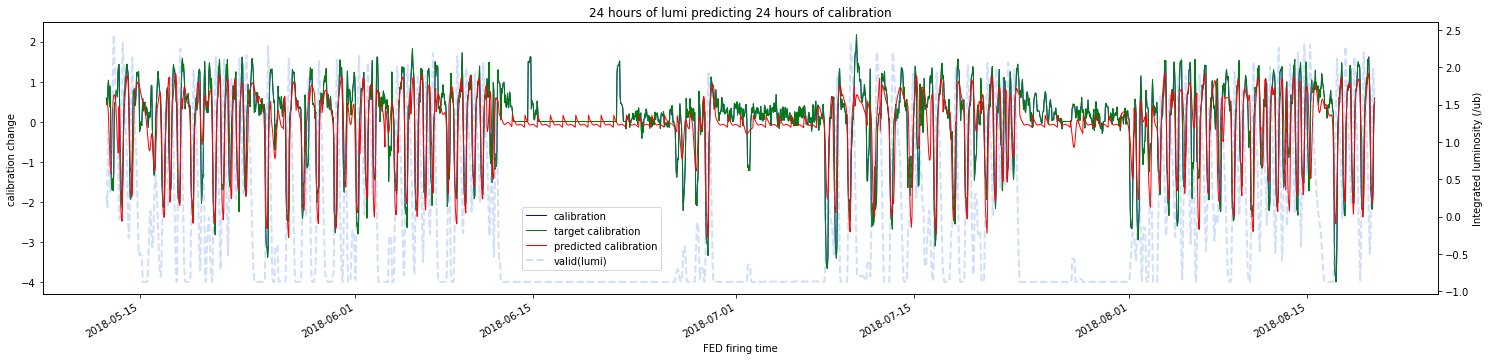

In [28]:
#lets plot the results

fig, ax = plt.subplots(figsize=(25,5))

ax.set_title('{T:.0f} hours of lumi predicting {T:.0f} hours of calibration'.format(T=HORIZON))
ax.set_ylabel('calibration change')
ax.set_xlabel('FED firing time')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

ax.plot(results_df.index, results_df.calibration, 
         label='calibration', color='blue', linewidth=1, linestyle='solid')
ax.plot(results_df.index, results_df.target_sequences, 
         label='target calibration', color='green', linewidth=1, linestyle='solid')
ax.plot(results_df.index, results_df.decoded_sequences, 
         label='predicted calibration', color='red', linewidth=1, linestyle='solid')
#lumi data on alternate y axis
ax2 = ax.twinx()
ax2.set_ylabel('Integrated luminosity (/ub)')

ax2.plot(results_df.index, results_df.int_deliv_inv_ub, 
         label='valid(lumi)', color='cornflowerblue', linewidth=2, linestyle='dashed',alpha=0.3)

#legend
fig.legend(ncol=1, loc = (0.35,0.25))
fig.show()

In [29]:
#here we will calculate our MAPE

apes = []
for i in range(0, results_df.calibration.count()):
    if results_df.target_sequences.iloc[i] == 0:
        continue
    ape = abs((results_df.decoded_sequences.iloc[i] - results_df.target_sequences.iloc[i]) / (results_df.target_sequences.iloc[i]))
    if np.isnan(ape):
        continue
    apes.append(ape)
    
mape1 = (sum(apes) / len(apes))

print('Evaluating seq2seq')
print("MAPE prediction: {:.2%}".format(mape1))

Evaluating seq2seq
MAPE prediction: 256.51%


In [30]:
#Now we want to look at the test data set
HORIZON = 24 #24hrs
test_shifted = test.copy()
test_calibration_shifted = test_shifted[['calibration']]
test_lumi_shifted = test_shifted[['int_deliv_inv_ub']]
for t in range(1, HORIZON):
    test_calibration_shifted['calibration+'+str(t)] = test_calibration_shifted['calibration'].shift(-t, freq='H')
    test_lumi_shifted['int_deliv_inv_ub+'+str(t)] = test_lumi_shifted['int_deliv_inv_ub'].shift(-t, freq='H')
#each row in each of the dataframes corresponds to 24hrs of data
test_target_seq = test_calibration_shifted.dropna()
test_input_seq = test_lumi_shifted.dropna()

#convert to np array
test_target_np = test_target_seq.to_numpy() #[row:column]
test_input_np = test_input_seq.to_numpy()

#we also want to create an 'over by 1' version of the target sequence to train the decoder
#we'll stick with a 0 padding for now
test_target_np_shifted = np.pad(test_target_np, ((0,0),(1,0)), mode='constant')[:,0:-1]

In [31]:
test_decoder_target_data = test_target_np
test_encoder_input_data = test_input_np
test_decoder_input_data = test_target_np_shifted

In [32]:
test_decoded_sequences = []
test_target_sequences = []
max_seq = 240
for seq_index in range(0,max_seq,HORIZON):
  #  print("========================================")
    # Take one sequence (part of the training set)
    # for trying out decoding.
    test_input_seq = test_encoder_input_data[seq_index : seq_index + 1]
    test_target_seq = test_decoder_target_data[seq_index: seq_index + 1]
 #   print("Input sequence:\n", input_seq)
    test_decoded_sequence = decode_sequence(test_input_seq)
 #  print("--------")
 #  print("Decoded sequence:\n", decoded_sequence)
 #   print("--------")
 #  print("Target sequence:\n", target_seq[0])
    test_decoded_sequences = np.concatenate((test_decoded_sequences, test_decoded_sequence))
    test_target_sequences = np.concatenate((test_target_sequences, test_target_seq[0]))


In [33]:
results_df = test.copy().iloc[:max_seq]
results_df['target_sequences'] = test_target_sequences
results_df['decoded_sequences'] = test_decoded_sequences

In [34]:
results_df

,calibration,int_deliv_inv_ub,target_sequences,decoded_sequences
2018-10-15 01:36:23,-0.166054,-0.869837,-0.166054,0.167927
2018-10-15 02:36:23,0.158291,-0.870851,0.158291,0.116561
2018-10-15 03:36:23,0.037582,-0.871358,0.037582,0.074530
2018-10-15 04:36:23,-0.163600,-0.867877,-0.163600,0.045527
2018-10-15 05:36:23,0.166209,-0.871797,0.166209,0.019982
...,...,...,...,...
2018-10-24 20:36:23,0.008907,-0.872372,0.008907,0.264192
2018-10-24 21:36:23,0.008907,-0.872372,0.008907,0.225080
2018-10-24 22:36:23,0.008907,-0.872372,0.008907,0.180317
2018-10-24 23:36:23,0.008907,-0.872372,0.008907,0.112329


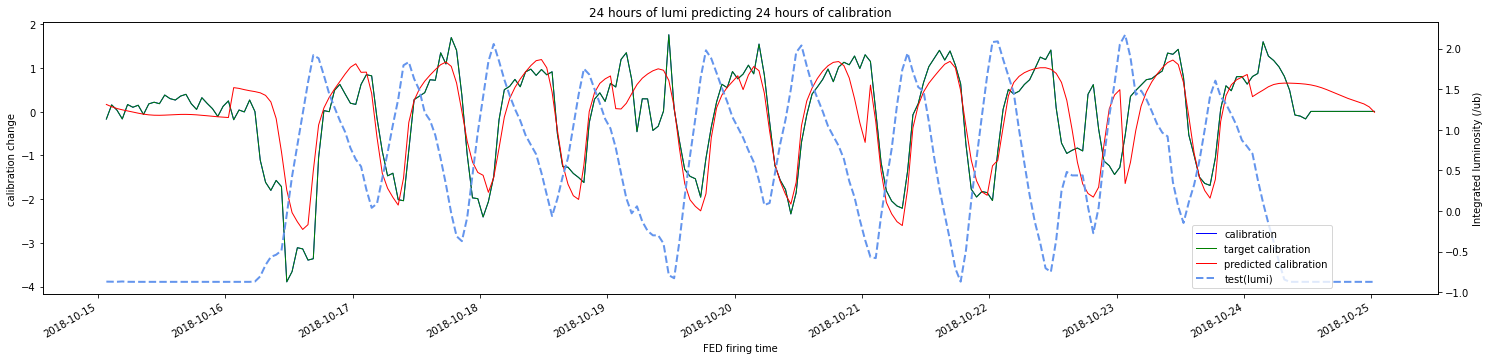

In [36]:
#lets plot the results

fig, ax = plt.subplots(figsize=(25,5))

ax.set_title('{T:.0f} hours of lumi predicting {T:.0f} hours of calibration'.format(T=HORIZON))
ax.set_ylabel('calibration change')
ax.set_xlabel('FED firing time')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

ax.plot(results_df.index, results_df.calibration, 
         label='calibration', color='blue', linewidth=1, linestyle='solid')
ax.plot(results_df.index, results_df.target_sequences, 
         label='target calibration', color='green', linewidth=1, linestyle='solid')
ax.plot(results_df.index, results_df.decoded_sequences, 
         label='predicted calibration', color='red', linewidth=1, linestyle='solid')
#lumi data on alternate y axis
ax2 = ax.twinx()
ax2.set_ylabel('Integrated luminosity (/ub)')

ax2.plot(results_df.index, results_df.int_deliv_inv_ub, 
         label='test(lumi)', color='cornflowerblue', linewidth=2, linestyle='dashed')

#legend
fig.legend(ncol=1, loc = (0.8,0.2))
fig.show()

In [37]:
#Now we can calculate the MAPE on the test set
apes = []
for i in range(0, results_df.calibration.count()):
    if results_df.target_sequences.iloc[i] == 0:
        continue
    ape = abs((results_df.decoded_sequences.iloc[i] - results_df.target_sequences.iloc[i]) / (results_df.target_sequences.iloc[i]))
    if np.isnan(ape):
        continue
    apes.append(ape)
    
mape1 = (sum(apes) / len(apes))

print('Evaluating seq2seq')
print("MAPE prediction: {:.2%}".format(mape1))

Evaluating seq2seq
MAPE prediction: 497.12%


In [32]:
####NOW LETS STUDY DATA FROM ANOTHER YEAR!


In [39]:
#load the data
test_16 = pd.read_csv('../dataframes/train_diff_16_54000.csv', index_col=0)


#set index to datetime
test_16.index = pd.to_datetime(test_16.index)

test_16.head()

,calibration,int_deliv_inv_ub
2016-05-12 15:45:16,0.000037,1.009344e+00
2016-05-12 16:45:16,0.000014,2.607296e+00
2016-05-12 17:45:16,0.000009,1.629892e+05
2016-05-12 18:45:16,-0.000090,8.571382e+05
2016-05-12 19:45:16,-0.000214,2.127250e+06


In [40]:
test_16[['calibration', 'int_deliv_inv_ub']] = scaler.transform(test_16)
test_16.describe()

,calibration,int_deliv_inv_ub
count,2648.000000,2648.000000
mean,-0.014443,-0.270922
std,0.691852,0.620076
min,-3.653894,-0.872372
25%,-0.166589,-0.872372
50%,0.117454,-0.457237
75%,0.354618,0.282871
max,2.261982,1.331666


In [41]:
#build the testing data
HORIZON = 24 #24hrs
test_shifted = test_16.copy()
test_calibration_shifted = test_shifted[['calibration']]
test_lumi_shifted = test_shifted[['int_deliv_inv_ub']]
for t in range(1, HORIZON):
    test_calibration_shifted['calibration+'+str(t)] = test_calibration_shifted['calibration'].shift(-t, freq='H')
    test_lumi_shifted['int_deliv_inv_ub+'+str(t)] = test_lumi_shifted['int_deliv_inv_ub'].shift(-t, freq='H')
#each row in each of the dataframes corresponds to 24hrs of data
test_target_seq = test_calibration_shifted.dropna()
test_input_seq = test_lumi_shifted.dropna()

#convert to np array
test_target_np = test_target_seq.to_numpy() #[row:column]
test_input_np = test_input_seq.to_numpy()

#we also want to create an 'over by 1' version of the target sequence to train the decoder
#we'll stick with a 0 padding for now
test_target_np_shifted = np.pad(test_target_np, ((0,0),(1,0)), mode='constant')[:,0:-1]

In [42]:
test_decoder_target_data = test_target_np
test_encoder_input_data = test_input_np
test_decoder_input_data = test_target_np_shifted

In [43]:
test_decoded_sequences = []
test_target_sequences = []
max_seq = 2400
for seq_index in range(0,max_seq,HORIZON):
    #print(seq_index)
  #  print("========================================")
    # Take one sequence (part of the training set)
    # for trying out decoding.
    test_input_seq = test_encoder_input_data[seq_index : seq_index + 1]
    test_target_seq = test_decoder_target_data[seq_index: seq_index + 1]
 #   print("Input sequence:\n", input_seq)
    test_decoded_sequence = decode_sequence(test_input_seq)
 #  print("--------")
 #  print("Decoded sequence:\n", decoded_sequence)
 #   print("--------")
 #  print("Target sequence:\n", target_seq[0])
    test_decoded_sequences = np.concatenate((test_decoded_sequences, test_decoded_sequence))
    test_target_sequences = np.concatenate((test_target_sequences, test_target_seq[0]))


In [44]:
test_target_sequences.shape

(2400,)

In [45]:
results_df = test_16.copy().iloc[:max_seq]
results_df['target_sequences'] = test_target_sequences
results_df['decoded_sequences'] = test_decoded_sequences

In [46]:
results_df

,calibration,int_deliv_inv_ub,target_sequences,decoded_sequences
2016-05-12 15:45:16,0.089542,-0.872372,0.089542,0.092757
2016-05-12 16:45:16,0.039026,-0.872372,0.039026,-0.082364
2016-05-12 17:45:16,0.028644,-0.862636,0.028644,-0.251434
2016-05-12 18:45:16,-0.186865,-0.821169,-0.186865,-0.438586
2016-05-12 19:45:16,-0.457830,-0.745296,-0.457830,-0.652192
...,...,...,...,...
2016-08-20 10:45:16,-0.133134,-0.872372,-0.133134,0.145479
2016-08-20 11:45:16,-0.015392,-0.872372,-0.015392,0.142445
2016-08-20 12:45:16,-0.093206,-0.872372,-0.093206,0.100099
2016-08-20 13:45:16,-0.115032,-0.872372,-0.115032,-0.005019


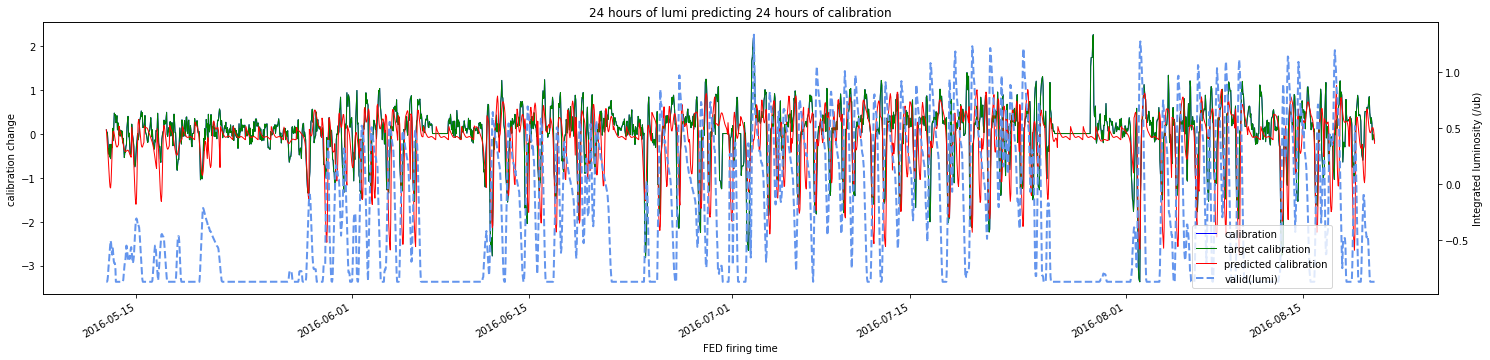

In [47]:
#lets plot the results

fig, ax = plt.subplots(figsize=(25,5))

ax.set_title('{T:.0f} hours of lumi predicting {T:.0f} hours of calibration'.format(T=HORIZON))
ax.set_ylabel('calibration change')
ax.set_xlabel('FED firing time')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

ax.plot(results_df.index, results_df.calibration, 
         label='calibration', color='blue', linewidth=1, linestyle='solid')
ax.plot(results_df.index, results_df.target_sequences, 
         label='target calibration', color='green', linewidth=1, linestyle='solid')
ax.plot(results_df.index, results_df.decoded_sequences, 
         label='predicted calibration', color='red', linewidth=1, linestyle='solid')

#lumi data on alternate y axis
ax2 = ax.twinx()
ax2.set_ylabel('Integrated luminosity (/ub)')

ax2.plot(results_df.index, results_df.int_deliv_inv_ub, 
         label='valid(lumi)', color='cornflowerblue', linewidth=2, linestyle='dashed')


#legend
fig.legend(ncol=1, loc = (0.8,0.2))
fig.show()

In [48]:
#And now we can calculate MAPE for 2016
apes = []
for i in range(0, results_df.calibration.count()):
    if results_df.target_sequences.iloc[i] == 0:
        continue
    ape = abs((results_df.decoded_sequences.iloc[i] - results_df.target_sequences.iloc[i]) / (results_df.target_sequences.iloc[i]))
    if np.isnan(ape):
        continue
    apes.append(ape)
    
mape1 = (sum(apes) / len(apes))

print('Evaluating seq2seq')
print("MAPE prediction: {:.2%}".format(mape1))

Evaluating seq2seq
MAPE prediction: 481.07%
